lol 1: Imports needed to run the following code.

In [1]:
import networkx as nx 
from fast_pagerank import pagerank_power # (Sajadi, 2017) 
import numpy as np
import random
import scipy as sp
from scipy.sparse import coo_matrix, identity
import pandas as pd
import copy
from timeit import default_timer as timer
from sklearn.metrics import ndcg_score
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

lol 2: Find the ancestors of every node given stochastic graph G, its list of strongly connected components C, and its condensation graph G1. Commented numbers refer to line numbers in Algorithm 1.

In [2]:
def find_all_ancestors(G, C, G1):
    ancestors = {node: set() for node in G.nodes} # (6) 
    predecessors = copy.deepcopy(C) # (6) 
    for node in nx.topological_sort(G1): # (5), (7)
        for pred in G1.predecessors(node): # (8)
            predecessors[node].update(predecessors[pred]) # (9)
        for original_node in C[node]: # (11)
            ancestors[original_node] = predecessors[node] # (12)
    return ancestors

lol 3: Implementation of Algorithm 1 to estimate the Personalised PageRank Matrix given a stochastic networkx graph and $\alpha$ where $1 - \alpha$ is the teleportation probability. Commented numbers refer to line numbers in Algorithm 1.

In [3]:
def T(Graph, alpha):
    n = len(Graph)
    
    A = nx.to_scipy_sparse_array(Graph, format='coo') 
    v = pagerank_power(A, p=alpha) # (1)
    m = 1/n*(n*v-(1-alpha)/alpha) # (2)
    C = list(nx.strongly_connected_components(Graph)) # (3)
    z = len(C)
    condensed_graph = nx.condensation(Graph, C) # (4)
    
    u = find_all_ancestors(Graph, C, condensed_graph)  # (5) - (14) 
    row_indices = []
    col_indices = []
    data = [] 

    for j, ancestors_set in u.items(): # (15)
        t = len(ancestors_set)
        row_indices.extend([j] * t)
        col_indices.extend(list(ancestors_set))
        data.extend([m[j]] * t)

    M = coo_matrix((data, (row_indices, col_indices)), shape=(n, n))
    eye_matrix = identity(n, format='coo') 
    M += ((1 - alpha) / alpha) * eye_matrix # (16) 
    M = (alpha + 0.0175) * M + (1 - alpha - 0.0175) * A.T # (17)

    return M, z 

lol 4: Generate a random stochastic graph with n nodes and k edges.

In [4]:
def generate_gnm(n,k):
    G = nx.gnm_random_graph(n, k, directed=True)
    G = nx.stochastic_graph(G)
    kc_A = nx.adjacency_matrix(G).todense().T 
    return G, kc_A

lol 5: Generate random stochastic graphs, estimate and calculate the Personalised PageRank Matrix. 'simulations' refers to the number of graphs generated. 'it' refers to the number of nodes we sample to compare their estimated personalised PageRank vector to their calculated personalised PageRank vector.

In [5]:
def fill_dataframe(dataframe, simulations, iter, min_nodes, max_nodes):
        for i in range(simulations):
                n = random.randint(min_nodes, max_nodes) #Thi 
                k = random.randint(3, 6)
                k *= n
                F, kc_B = generate_gnm(n,k)
                n = len(F)
                start = timer()
                A, s = T(F, 0.85)
                end = timer()
                t1 = end - start
                A = A.toarray()
                p = []
                t = []
                for j in np.random.randint(0, n, iter): 
                        pers = np.zeros(n)
                        pers[j]=1
                        start = timer()
                        Bv = pagerank_power(kc_B.T, p=0.85, max_iter=30,
                        personalize=pers, tol=1e-8)
                        end = timer()
                        t.append(end-start)
                        p.append(ndcg_score(Bv.reshape(1, -1), A[:,j].reshape(1, -1)))

                dataframe.loc[len(dataframe.index)] = [n, k, s, t1,
                n*sum(t)/iter, sum(p)/iter]
                print(i)
        return dataframe

lol 6: Estimate and calculate the Personalised PageRank Matrix for a specified stochastic graph graph. Make sure columns not the rows of the adjacancy Matrix add up to 1. 'it' refers to the number of nodes we sample to compare their estimated personalised PageRank vector to their calculated personalised PageRank vector.

In [6]:
def fill_dataframe_row(dataframe, graph, adjacancy_matrix, it):
        F = graph
        kc_B = adjacancy_matrix
        n = len(F)
        k = len(graph.edges())
        start = timer()
        A, s = T(F, 0.85)
        A = A.toarray()
        end = timer()
        t1 = end - start
        p = []
        t = []
        i = 1
        for j in np.random.randint(0, n, it): #change back to n
                pers = np.zeros(n)
                pers[j]=1
                start = timer()
                Bv = pagerank_power(kc_B.T, p=0.85, max_iter=30,
                personalize=pers, tol=1e-8)
                end = timer()
                t.append(end-start)
                p.append(ndcg_score(Bv.reshape(1, -1),
                A[:,j].reshape(1, -1)))
                print(i)
                i+=1 
        dataframe.loc[len(dataframe.index)] = [n, k, s, t1,
        n*sum(t)/iter, sum(p)/iter]
        return dataframe

lol 7: Example usage: Generate 100 graphs with less than 1000 nodes and plot the results (takes about 30 seconds).

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


[Text(0.5, 1.0, 'Number of Nodes compared to Runtime for Approximation Matrix')]

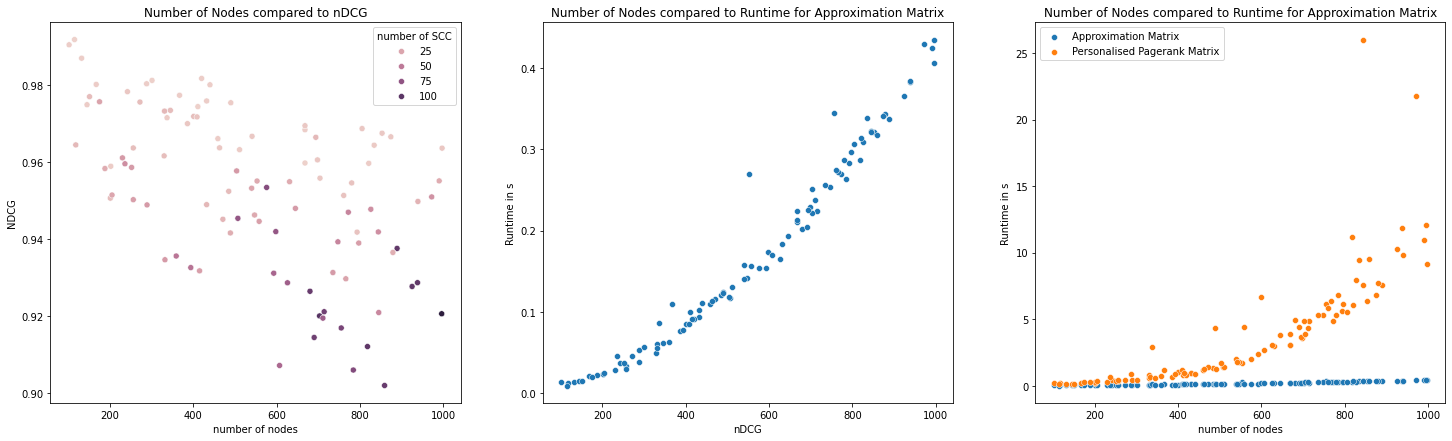

In [8]:
df = pd.DataFrame(columns=['number of nodes','number of edges','number of SCC',
                           'time for approximation','Minimum time for PPM', 'NDCG'])
fill_dataframe(df, simulations = 100, iter = 10, min_nodes = 100, max_nodes = 1000)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 7))
sns.scatterplot(x=df['number of nodes'], y =df['NDCG'], hue=df['number of SCC'], ax=ax1)
sns.scatterplot(x=df['number of nodes'], y =df['time for approximation'], ax=ax2)
sns.scatterplot(x=df['number of nodes'], y =df['time for approximation'], ax=ax3,
label = 'Approximation Matrix')
sns.scatterplot(x=df['number of nodes'], y =df['Minimum time for PPM'], ax=ax3,
label = 'Personalised Pagerank Matrix')

ax3.legend(loc="upper left")
ax1.set(title='Number of Nodes compared to nDCG')
ax2.set_xlabel('nDCG')
ax2.set_ylabel('Runtime in s')
ax3.set_ylabel('Runtime in s')
ax2.set(title='Number of Nodes compared to Runtime for Approximation Matrix')
ax3.set(title='Number of Nodes compared to Runtime for Approximation Matrix')